In the this part, we will try and implement a few machine learning algorithms over the original dataset with added external features or factors. We will add holiday and weather as features to help improve the accuracy. 

We will use RMSLE(Root Mean Square Logarithamic Error) as performance measure. 
RMSLE measures the ratio between actual and predicted.

log(pi+1)−log(ai+1)

can be written as log((pi+1)/(ai+1))

It can be used when you don’t want to penalize huge differences when both the values are huge numbers.

Also, this can be used when you want to penalize under estimates more than over estimates.

<h2>XGBoost</h2>

XGBoost is an algorithm that has recently been dominating applied machine learning for structured or tabular data. XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. 
Why Use XGBoost?
The two reasons to use XGBoost are also the two goals of the project:

Execution Speed.
Model Performance.
1. XGBoost Execution Speed
Generally, XGBoost is fast. Really fast when compared to other implementations of gradient boosting.
2. XGBoost Model Performance
XGBoost dominates structured or tabular datasets on classification and regression predictive modeling problems.

<h3>How to install xgboost module in Python</h3>

1. Download the Appropriate .whl file for your environment from https://www.lfd.uci.edu/~gohlke/pythonlibs/#xgboost
for me as I am using 64-bit Python 3.6, I downloaded xgboost-0.71-cp36-cp36m-win_amd64.whl file. My python is 64-bit and not my system, so make sure you check that before downloading the .whl file

2. Open your command prompt and cd into the downloaded folder.

3. Now simply issue the pip install command to the downloaded .whl file like so:

   <b>pip install xgboost-0.71-cp36-cp36m-win_amd64.whl</b>
   
4. If you have downloaded the wrong file it will give you an error saying whl file not supported for this platform

In [1]:
import pandas as pd
import numpy as np
import datetime
from haversine import haversine
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pyplot import *
from matplotlib import cm
from matplotlib import animation
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

<h3>Reading and Loading external data into a dataframe</h3>

In [2]:
import os
path = os.getcwd()
print(path)

C:\Users\ninad\Desktop\BDSIN\Final Project\Scripts


In [3]:
df_train = pd.read_csv(path+'/train.csv', parse_dates=['pickup_datetime','dropoff_datetime'])
fast_route_1 = pd.read_csv(path+'/fastest_routes_train_part_1.csv')

fast_route_2 = pd.read_csv(path+'/fastest_routes_train_part_2.csv')

fast_route = pd.concat([fast_route_1,fast_route_2])
fast_route_new = fast_route[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
train_df = pd.merge(df_train, fast_route_new, on = 'id', how = 'left')
train_new = train_df.copy()

In [4]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


<h3>Reading the test file</h3>

In [5]:
df_test = pd.read_csv(path+'/test.csv', parse_dates=['pickup_datetime'])
fast_route_test = pd.read_csv(path+'/fastest_routes_test.csv')
fast_route_test_new = fast_route_test[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
test_df = pd.merge(df_test, fast_route_test_new, on = 'id', how = 'left')
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,total_distance,total_travel_time,number_of_steps
0,id3004672,1,2016-06-30 23:59:00,1,-73.988129,40.732029,-73.990173,40.756680,N,3795.9,424.6,4
1,id3505355,1,2016-06-30 23:59:00,1,-73.964203,40.679993,-73.959808,40.655403,N,2904.5,200.0,4
2,id1217141,1,2016-06-30 23:59:00,1,-73.997437,40.737583,-73.986160,40.729523,N,1499.5,193.2,4
3,id2150126,2,2016-06-30 23:59:00,1,-73.956070,40.771900,-73.986427,40.730469,N,7023.9,494.8,11
4,id1598245,1,2016-06-30 23:59:00,1,-73.970215,40.761475,-73.961510,40.755890,N,1108.2,103.2,4


In [6]:
#Extracting date from the datetime column from test and train
train_df.loc[:, 'pickup_date'] = train_df['pickup_datetime'].dt.date
train_df.loc[:, 'dropoff_date'] = train_df['dropoff_datetime'].dt.date
test_df.loc[:, 'pickup_date'] = test_df['pickup_datetime'].dt.date

In [7]:
#Converting the store_and_fwd_flag into categorical variable
train_df['store_and_fwd_flag'] = 1 * (train_df.store_and_fwd_flag.values == 'Y')
test_df['store_and_fwd_flag'] = 1 * (test_df.store_and_fwd_flag.values == 'Y')

In [8]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,total_distance,total_travel_time,number_of_steps,pickup_date,dropoff_date
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,2009.1,164.9,5.0,2016-03-14,2016-03-14
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2513.2,332.0,6.0,2016-06-12,2016-06-12
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,11060.8,767.6,16.0,2016-01-19,2016-01-19
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,1779.4,235.8,4.0,2016-04-06,2016-04-06
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,1614.9,140.1,5.0,2016-03-26,2016-03-26


<h3><b>Feature Extraction</b></h3>

In machine learning, pattern recognition and in image processing, feature extraction starts from an initial set of measured data and builds derived values (features) intended to be informative and non-redundant, facilitating the subsequent learning and generalization steps, and in some cases leading to better human interpretations. Feature extraction is related to dimensionality reduction.

When the input data to an algorithm is too large to be processed and it is suspected to be redundant (e.g. the same measurement in both feet and meters, or the repetitiveness of images presented as pixels), then it can be transformed into a reduced set of features (also named a feature vector). Determining a subset of the initial features is called feature selection.The selected features are expected to contain the relevant information from the input data, so that the desired task can be performed by using this reduced representation instead of the complete initial data

<h3>Principal Component Analysis</h3>

Sometimes data are collected on a large number of variables from a single population. With a large number of variables, the dispersion matrix may be too large to study and interpret properly. There would be too many pairwise correlations between the variables to consider. Graphical displays may also not be particularly helpful when the data set is very large. With 12 variables, for example, there will be more than 200 three-dimensional scatterplots. To interpret the data in a more meaningful form, it is necessary to reduce the number of variables to a few, interpretable linear combinations of the data. Each linear combination will correspond to a principal component.<b>We use PCA to transform longitude and latitude coordinates.
In this case it is not about dimension reduction since we transform 2D-> 2D. The rotation could help for decision tree splits.</b>. With rotation the principal components are more specifically associated with the original variables. The maximum likelihood solution is undefined down to an orthogonal transformation (ie rotations) of the factor loadings. That is, any rotation of the factor loadings is an equally good solutions. So it makes sense to rotate these loadings in a way which maximises ease of interpretation.

In [9]:
#Stack arrays in sequence vertically (row wise).
coords = np.vstack((train_df[['pickup_latitude', 'pickup_longitude']].values,
                    train_df[['dropoff_latitude', 'dropoff_longitude']].values,
                    train_df[['pickup_latitude', 'pickup_longitude']].values,
                    train_df[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)

train_df['pickup_pca0'] = pca.transform(train_df[['pickup_latitude', 'pickup_longitude']])[:,0]
train_df['pickup_pca1'] = pca.transform(train_df[['pickup_latitude', 'pickup_longitude']])[:,1]
train_df['dropoff_pca0'] = pca.transform(train_df[['dropoff_latitude', 'dropoff_longitude']])[:,0]
train_df['dropoff_pca1'] = pca.transform(train_df[['dropoff_latitude', 'dropoff_longitude']])[:,1]

test_df['pickup_pca0'] = pca.transform(test_df[['pickup_latitude', 'pickup_longitude']])[:,0]
test_df['pickup_pca1'] = pca.transform(test_df[['pickup_latitude', 'pickup_longitude']])[:,1]
test_df['dropoff_pca0'] = pca.transform(test_df[['dropoff_latitude', 'dropoff_longitude']])[:,0]
test_df['dropoff_pca1'] = pca.transform(test_df[['dropoff_latitude', 'dropoff_longitude']])[:,1]

In [10]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,total_distance,total_travel_time,number_of_steps,pickup_date,dropoff_date,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,455,2009.1,164.9,5.0,2016-03-14,2016-03-14,0.007896,0.016976,-0.009496,0.013801
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,663,2513.2,332.0,6.0,2016-06-12,2016-06-12,0.007572,-0.012447,0.026972,-0.018933
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,11060.8,767.6,16.0,2016-01-19,2016-01-19,0.004964,0.012832,0.033831,-0.039692
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,429,1779.4,235.8,4.0,2016-04-06,2016-04-06,0.038057,-0.029593,0.040920,-0.042722
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,435,1614.9,140.1,5.0,2016-03-26,2016-03-26,-0.002411,0.041781,-0.002026,0.031099


<b>Haversine Distance:</b> The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes.

<b>Manhattan Distance:</b> The distance between two points in a grid based on a strictly horizontal and/or vertical path (that is, along the grid lines), as opposed to the diagonal or "as the crow flies" distance.

<b>Bearing Distance:</b> The bearing (or azimuth) is the compass direction to travel from the starting point, and must be within the range 0 to 360. 0 represents north, 90 is east, 180 is south and 270 is west.

In [11]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2)) #applies a function to all the items in an input_list
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2)) #applies a function to all the items in an input_list
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

We will apply the above three functions to the columns in train and test dataframe

In [12]:
train_df.loc[:, 'distance_haversine'] = haversine_array(train_df['pickup_latitude'].values, train_df['pickup_longitude'].values, train_df['dropoff_latitude'].values, train_df['dropoff_longitude'].values)
train_df.loc[:, 'distance_manhattan'] = dummy_manhattan_distance(train_df['pickup_latitude'].values, train_df['pickup_longitude'].values, train_df['dropoff_latitude'].values, train_df['dropoff_longitude'].values)
train_df.loc[:, 'direction'] = bearing_array(train_df['pickup_latitude'].values, train_df['pickup_longitude'].values, train_df['dropoff_latitude'].values, train_df['dropoff_longitude'].values)
train_df.loc[:, 'pca_manhattan'] = np.abs(train_df['dropoff_pca1'] - train_df['pickup_pca1']) + np.abs(train_df['dropoff_pca0'] - train_df['pickup_pca0'])

In [13]:
test_df.loc[:, 'distance_haversine'] = haversine_array(test_df['pickup_latitude'].values, test_df['pickup_longitude'].values, test_df['dropoff_latitude'].values, test_df['dropoff_longitude'].values)
test_df.loc[:, 'distance_manhattan'] = dummy_manhattan_distance(test_df['pickup_latitude'].values, test_df['pickup_longitude'].values, test_df['dropoff_latitude'].values, test_df['dropoff_longitude'].values)
test_df.loc[:, 'direction'] = bearing_array(test_df['pickup_latitude'].values, test_df['pickup_longitude'].values, test_df['dropoff_latitude'].values, test_df['dropoff_longitude'].values)
test_df.loc[:, 'pca_manhattan'] = np.abs(test_df['dropoff_pca1'] - test_df['pickup_pca1']) + np.abs(test_df['dropoff_pca0'] - test_df['pickup_pca0'])

In [14]:
train_df.loc[:, 'center_latitude'] = (train_df['pickup_latitude'].values + train_df['dropoff_latitude'].values)/2
train_df.loc[:, 'center_longitude'] = (train_df['pickup_longitude'].values + train_df['dropoff_longitude'].values)/2
test_df.loc[:, 'center_latitude'] = (test_df['pickup_latitude'].values + test_df['dropoff_latitude'].values)/2
test_df.loc[:, 'center_longitude'] = (test_df['pickup_longitude'].values + test_df['dropoff_longitude'].values)/2

<h4>Extract all the datetime features</h4>

In [15]:
train_df.loc[:, 'pickup_weekday'] = train_df['pickup_datetime'].dt.weekday
train_df.loc[:, 'pickup_hour_weekofyear'] = train_df['pickup_datetime'].dt.weekofyear
train_df.loc[:, 'pickup_hour'] = train_df['pickup_datetime'].dt.hour
train_df.loc[:, 'pickup_minute'] = train_df['pickup_datetime'].dt.minute
train_df.loc[:, 'pickup_dt'] = (train_df['pickup_datetime'] - train_df['pickup_datetime'].min()).dt.total_seconds()
train_df.loc[:, 'pickup_week_hour'] = train_df['pickup_weekday'] * 24 + train_df['pickup_hour']

In [16]:
test_df.loc[:, 'pickup_weekday'] = test_df['pickup_datetime'].dt.weekday
test_df.loc[:, 'pickup_hour_weekofyear'] = test_df['pickup_datetime'].dt.weekofyear
test_df.loc[:, 'pickup_hour'] = test_df['pickup_datetime'].dt.hour
test_df.loc[:, 'pickup_minute'] = test_df['pickup_datetime'].dt.minute
test_df.loc[:, 'pickup_dt'] = (test_df['pickup_datetime'] - test_df['pickup_datetime'].min()).dt.total_seconds()
test_df.loc[:, 'pickup_week_hour'] = test_df['pickup_weekday'] * 24 + test_df['pickup_hour']

<h3>Extract the Speed feature using the Haversine Distance and trip duration</h3>

We will use the basic speed is equal to distance upon time formula

In [17]:
train_df.loc[:, 'avg_speed_h'] = 1000 * train_df['distance_haversine']/train_df['trip_duration']
train_df.loc[:, 'avg_speed_m'] = 1000 * train_df['distance_manhattan']/train_df['trip_duration']

In [18]:
test_df.loc[:, 'avg_speed_h'] = 1000 * train_df['distance_haversine']/train_df['trip_duration']
test_df.loc[:, 'avg_speed_m'] = 1000 * train_df['distance_manhattan']/train_df['trip_duration']

In [19]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,center_latitude,center_longitude,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,avg_speed_h,avg_speed_m
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,0,...,40.766769,-73.973392,0,11,17,24,6369878.0,17,3.293452,3.814139
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,0,...,40.734858,-73.989948,6,23,0,43,14085798.0,144,2.723239,3.665922
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,0,...,40.737013,-73.992180,1,3,11,35,1596907.0,35,3.006167,3.862323
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,0,...,40.713345,-74.011154,2,14,19,32,8364734.0,67,3.462700,3.872567
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,0,...,40.787865,-73.972988,5,12,13,30,7392638.0,133,2.732387,2.757372


<h3>Adding holiday as a feature</h3>

We will add all the US holidays as holiday feature from the available library 

In [20]:
import holidays
from datetime import date, datetime
us_holidays = holidays.UnitedStates()

In [21]:
#If that particular day is a holiday then it will be marked as 1 otherwise 0
train_df.loc[:, 'holiday'] = train_df.pickup_datetime.apply(lambda x: 1 if x in us_holidays else 0)

In [22]:
#Same for the test data
test_df.loc[:, 'holiday'] = train_df.pickup_datetime.apply(lambda x: 1 if x in us_holidays else 0)

<h3>Adding weather as a feature</h3>

First we will import the weather data into a dataframe

In [23]:
import os
path = os.getcwd()+'\weather_data_nyc_centralpark_2016.csv'
weather_df = pd.read_csv(path)
weather_df.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,1-1-2016,42,34,38.0,0.00,0.0,0
1,2-1-2016,40,32,36.0,0.00,0.0,0
2,3-1-2016,45,35,40.0,0.00,0.0,0
3,4-1-2016,36,14,25.0,0.00,0.0,0
4,5-1-2016,29,11,20.0,0.00,0.0,0


In [24]:
weather_df['DATE'] = pd.to_datetime(weather_df.date) #as the format of date in data varies we will convert it into one format
weather_df['pickup_date'] = weather_df['DATE'].dt.date #rename the column name
del weather_df['date']

In [25]:
#We will merge the weather data with the train and test data
train_df = pd.merge(train_df, weather_df, on = 'pickup_date', how = 'left')
test_df = pd.merge(test_df, weather_df, on = 'pickup_date', how = 'left')

  snow fall  trip_duration
0         0     931.256312
1       0.0     973.658589
2       0.2     934.412834
3       0.4     906.369139
4       0.5     828.804774
5       1.4     813.655093
6       2.5     875.932462
7      27.3    1026.549757
8         T     899.071886


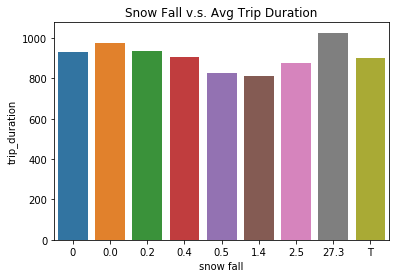

In [26]:
#We will try and visualize how weather affected the trip duration
a = train_df.groupby(['snow fall']).mean()['trip_duration'].reset_index()
print(a)
sns.barplot(x="snow fall", y='trip_duration', data=a)
plt.xlabel('snow fall')
plt.ylabel('trip_duration')
plt.title('Snow Fall v.s. Avg Trip Duration')
plt.show()

<h5>From the above graph it is clearly visible that during snowfall the drip duration of the taxi ride increased</h5>

In [27]:
#We will create a lookup for the 'T' value in snowfall column so as to convert it into float 0.01
lookup = {"snow fall": {"T": 0.01},
          "snow depth": {"T": 0.01},
          'precipitation': {"T": 0.01}}
train_df.replace(lookup, inplace=True)
train_df['snow fall'] = train_df['snow fall'].astype('float')
train_df['snow depth'] = train_df['snow depth'].astype('float')
train_df['precipitation'] = train_df['precipitation'].astype('float')

In [28]:
#We will do the same thing for test data
test_df.replace(lookup, inplace=True)
test_df['snow fall'] = test_df['snow fall'].astype('float')
test_df['snow depth'] = test_df['snow depth'].astype('float')
test_df['precipitation'] = test_df['precipitation'].astype('float')

In [29]:
#After adding all the extra features, we will check for the datatype of all the columns in train and test
train_df.dtypes

id                                object
vendor_id                          int64
pickup_datetime           datetime64[ns]
dropoff_datetime          datetime64[ns]
passenger_count                    int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
store_and_fwd_flag                 int32
trip_duration                      int64
total_distance                   float64
total_travel_time                float64
number_of_steps                  float64
pickup_date                       object
dropoff_date                      object
pickup_pca0                      float64
pickup_pca1                      float64
dropoff_pca0                     float64
dropoff_pca1                     float64
distance_haversine               float64
distance_manhattan               float64
direction                        float64
pca_manhattan                    float64
center_latitude 

In [30]:
#We will also check for null values in train data
train_df.isnull().sum()

id                        0
vendor_id                 0
pickup_datetime           0
dropoff_datetime          0
passenger_count           0
pickup_longitude          0
pickup_latitude           0
dropoff_longitude         0
dropoff_latitude          0
store_and_fwd_flag        0
trip_duration             0
total_distance            1
total_travel_time         1
number_of_steps           1
pickup_date               0
dropoff_date              0
pickup_pca0               0
pickup_pca1               0
dropoff_pca0              0
dropoff_pca1              0
distance_haversine        0
distance_manhattan        0
direction                 0
pca_manhattan             0
center_latitude           0
center_longitude          0
pickup_weekday            0
pickup_hour_weekofyear    0
pickup_hour               0
pickup_minute             0
pickup_dt                 0
pickup_week_hour          0
avg_speed_h               0
avg_speed_m               0
holiday                   0
maximum temperature 

In [31]:
#The 3 columns having null values will be replaced with the mean value of that particular column
train_df['total_distance'].fillna((train_df['total_distance'].mean()), inplace=True)
train_df['total_travel_time'].fillna((train_df['total_travel_time'].mean()), inplace=True)
train_df['number_of_steps'].fillna((train_df['number_of_steps'].mean()), inplace=True)

In [32]:
test_df.isnull().sum()

id                        0
vendor_id                 0
pickup_datetime           0
passenger_count           0
pickup_longitude          0
pickup_latitude           0
dropoff_longitude         0
dropoff_latitude          0
store_and_fwd_flag        0
total_distance            0
total_travel_time         0
number_of_steps           0
pickup_date               0
pickup_pca0               0
pickup_pca1               0
dropoff_pca0              0
dropoff_pca1              0
distance_haversine        0
distance_manhattan        0
direction                 0
pca_manhattan             0
center_latitude           0
center_longitude          0
pickup_weekday            0
pickup_hour_weekofyear    0
pickup_hour               0
pickup_minute             0
pickup_dt                 0
pickup_week_hour          0
avg_speed_h               0
avg_speed_m               0
holiday                   0
maximum temperature       0
minimum temperature       0
average temperature       0
precipitation       

We will add the names of all the columns in train into a list and the list of not required columns to exclude list

In [33]:
feature_names = list(train_df.columns)
exclude = ['id','pickup_datetime','dropoff_datetime','trip_duration','pickup_date','dropoff_date','DATE']
feature_names = [f for f in train_df.columns if f not in exclude]
train_df[feature_names].count()

vendor_id                 1458644
passenger_count           1458644
pickup_longitude          1458644
pickup_latitude           1458644
dropoff_longitude         1458644
dropoff_latitude          1458644
store_and_fwd_flag        1458644
total_distance            1458644
total_travel_time         1458644
number_of_steps           1458644
pickup_pca0               1458644
pickup_pca1               1458644
dropoff_pca0              1458644
dropoff_pca1              1458644
distance_haversine        1458644
distance_manhattan        1458644
direction                 1458644
pca_manhattan             1458644
center_latitude           1458644
center_longitude          1458644
pickup_weekday            1458644
pickup_hour_weekofyear    1458644
pickup_hour               1458644
pickup_minute             1458644
pickup_dt                 1458644
pickup_week_hour          1458644
avg_speed_h               1458644
avg_speed_m               1458644
holiday                   1458644
maximum temper

In [34]:
print(feature_names)

['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'total_distance', 'total_travel_time', 'number_of_steps', 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 'distance_haversine', 'distance_manhattan', 'direction', 'pca_manhattan', 'center_latitude', 'center_longitude', 'pickup_weekday', 'pickup_hour_weekofyear', 'pickup_hour', 'pickup_minute', 'pickup_dt', 'pickup_week_hour', 'avg_speed_h', 'avg_speed_m', 'holiday', 'maximum temperature', 'minimum temperature', 'average temperature', 'precipitation', 'snow fall', 'snow depth']


In [35]:
train_df[feature_names].dtypes

vendor_id                   int64
passenger_count             int64
pickup_longitude          float64
pickup_latitude           float64
dropoff_longitude         float64
dropoff_latitude          float64
store_and_fwd_flag          int32
total_distance            float64
total_travel_time         float64
number_of_steps           float64
pickup_pca0               float64
pickup_pca1               float64
dropoff_pca0              float64
dropoff_pca1              float64
distance_haversine        float64
distance_manhattan        float64
direction                 float64
pca_manhattan             float64
center_latitude           float64
center_longitude          float64
pickup_weekday              int64
pickup_hour_weekofyear      int64
pickup_hour                 int64
pickup_minute               int64
pickup_dt                 float64
pickup_week_hour            int64
avg_speed_h               float64
avg_speed_m               float64
holiday                     int64
maximum temper

In [38]:
#***************************************************************************************
#*    This was adapted from a post from
#*    Author: Kulbear
#*    Date: 04/23/2018
#*    Availability: https://github.com/Kulbear/New-York-City-Taxi-Trip-Duration/blob/master/xgboost.ipynb
#*
#***************************************************************************************/

import xgboost as xgb
y = np.log(train_df['trip_duration'].values + 1) #We will convert the trip duration into logarithmic values for the sake of ML
train_x, val_x, train_y, val_y = train_test_split(train_df[feature_names].values, y, test_size=0.2) # split the dataset into train and test

#The data is stored in a DMatrix object
#Missing values can be replaced by a default value in the DMatrix constructor
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(val_x, label=val_y )
dtest = xgb.DMatrix(test_df[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# We have used random search for XGBoost
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [39]:
# You could try to train with more epoch,the rmse value might stall after few epochs sometimes
model = xgb.train(xgb_pars, dtrain, 100, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

#If you have a validation set, you can use early stopping to find the optimal number of boosting rounds. 
#Early stopping requires at least one set in evals. If there’s more than one, it will use the last.
#train(..., evals=evals, early_stopping_rounds=10)

[0]	train-rmse:4.21862	valid-rmse:4.21747
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.176757	valid-rmse:0.181808
[20]	train-rmse:0.108635	valid-rmse:0.118087
[30]	train-rmse:0.10046	valid-rmse:0.112307
[40]	train-rmse:0.095502	valid-rmse:0.110124
[50]	train-rmse:0.0919	valid-rmse:0.10861
[60]	train-rmse:0.088545	valid-rmse:0.107903
[70]	train-rmse:0.086194	valid-rmse:0.107953
[80]	train-rmse:0.083958	valid-rmse:0.107904
[90]	train-rmse:0.080878	valid-rmse:0.108227
[99]	train-rmse:0.07929	valid-rmse:0.108135


In [40]:
print('Modeling RMSLE %.5f' % model.best_score)

Modeling RMSLE 0.10775


In [41]:
predictions = model.predict(dvalid)

In [42]:
#Predicted values
y_pred = np.exp(predictions)-1
print(y_pred[:10])
y_pred = pd.DataFrame(y_pred, columns = ['y_pred'])

[ 399.8948   222.12178  916.3345  1128.9053   241.03188 3114.3386
 2042.732    916.4408  1773.5358   429.2949 ]


In [43]:
#Original values
y_org = np.exp(val_y)-1
print(y_org[:10])
y_org= pd.DataFrame(y_org, columns = ['y_org'])

[ 393.  216.  940. 1136.  239. 3140. 2227.  990. 1683.  434.]


In [44]:
#Comparing the predicted and original values
result = pd.concat([y_org,y_pred], axis=1)
result.head()

,y_org,y_pred
0,393.0,399.894806
1,216.0,222.121780
2,940.0,916.334473
3,1136.0,1128.905273
4,239.0,241.031876


<h2>Random Forest Regressor</h2>

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.Random decision forests correct for decision trees' habit of overfitting to their training set.

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default)

Randomized search on hyper parameters.

RandomizedSearchCV implements a “fit” and a “score” method. It also implements “predict”, “predict_proba”, “decision_function”, “transform” and “inverse_transform” if they are implemented in the estimator used.

The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings.

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

If all parameters are presented as a list, sampling without replacement is performed. If at least one parameter is given as a distribution, sampling with replacement is used. It is highly recommended to use continuous distributions for continuous parameters.

In [45]:
from sklearn import datasets
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestRegressor(random_state =42)#random_state is the seed used by the random number generator;

#We will try and select the best parameters for Random Forest to give good accuracy
param_grid = {"max_depth": [10,20,30],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11)}

validator = RandomizedSearchCV(clf, param_distributions= param_grid) #clf is the estimator and
validator.fit(train_x,train_y)
#param_distributions : dict
#Dictionary with parameters names (string) as keys and distributions or lists of parameters to try

print(validator.best_score_)
print(validator.best_estimator_.n_estimators)
print(validator.best_estimator_.max_depth)
print(validator.best_estimator_.min_samples_split)
print(validator.best_estimator_.min_samples_leaf)
print(validator.best_estimator_.max_features)

0.9826610120711197
10
20
5
1
10


<h6>RandomForestRegressor</h6>

<h6>max_depth</h6> : integer or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

<h6>min_samples_split</h6>int, float, optional (default=2)
The minimum number of samples required to split an internal node:

<h6>min_samples_leaf</h6>int, float, optional (default=1)
The minimum number of samples required to be at a leaf node:

<h6>n_estimators</h6>: The number of trees in the forest.

<h6>max_features</h6>: The number of features to consider when looking for the best split

You can vary the features and see it the rmse value decreases

In [46]:
rf_model = RandomForestRegressor(max_depth = 20 , min_samples_split= 2, 
                                 min_samples_leaf=5, n_estimators =10, max_features =8)
rf_model.fit(train_x,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [47]:
#Predicting on validation set
predictions = rf_model.predict(val_x)

In [48]:
#RMSLE error
from sklearn.metrics import mean_squared_error
#tree_pred = pd.DataFrame(predictions)
dec_mse = mean_squared_error(predictions, val_y)
rmse = np.sqrt(dec_mse)
print(rmse) 

0.11033131704917128


<h2>Lasso & Ridge Regularization</h2>

Ridge and Lasso regression are powerful techniques generally used for creating parsimonious models in presence of a ‘large’ number of features. Here ‘large’ can typically mean either of two things:
    1.Large enough to enhance the tendency of a model to overfit (as low as 10 variables might cause overfitting)
    2.Large enough to cause computational challenges. With modern systems, this situation might arise in case of millions or   billions of features
  
Though Ridge and Lasso might appear to work towards a common goal, the inherent properties and practical use cases differ substantially. If you’ve heard of them before, you must know that they work by penalizing the magnitude of coefficients of features along with minimizing the error between predicted and actual observations. These are called ‘regularization’ techniques. The key difference is in how they assign penalty to the coefficients:

Ridge Regression:
Performs L2 regularization, i.e. adds penalty equivalent to square of the magnitude of coefficients
Minimization objective = LS Obj + α * (sum of square of coefficients)

Lasso Regression:
Performs L1 regularization, i.e. adds penalty equivalent to absolute value of the magnitude of coefficients
Minimization objective = LS Obj + α * (sum of absolute value of coefficients)

<h6>param_grid :</h6> dict of string to sequence, or sequence of such

The parameter grid to explore, as a dictionary mapping estimator parameters to sequences of allowed values.

An empty dict signifies default parameters.

A sequence of dicts signifies a sequence of grids to search, and is useful to avoid exploring parameter combinations that make no sense or have no effect. See the examples below.

<h3>Ridge</h3>

In [49]:
#Ridge
from sklearn import datasets
from sklearn.linear_model import Ridge
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

#This model solves a regression model 
#where the loss function is the linear least squares function and regularization is given by the l2-norm
ridge = Ridge()

#param_grid will be give a range of values for alpha, which provides regularization strength in Ridge function
param_grid = {"alpha": [0.01,0.05,0.001,0.0001,0.000001,0.005,0.0005,0.00005]}

validator = GridSearchCV(ridge, param_grid= param_grid) 
validator.fit(train_x,train_y)
print(validator.best_score_)
print(validator.best_estimator_.alpha)

0.49843961136619813
0.05


In [50]:
#‘cholesky’ uses the standard scipy.linalg.solve function to obtain a closed-form solution.
ridge_reg = Ridge(alpha = 0.05, solver = 'cholesky')
ridge_reg.fit(train_x,train_y)

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='cholesky', tol=0.001)

In [51]:
predictions_ridge = ridge_reg.predict(val_x)

In [52]:
dec_mse_ridge = mean_squared_error(predictions_ridge, val_y)
rmse_ridge = np.sqrt(dec_mse_ridge)
print(rmse_ridge) 

0.5108069344777587


<h3>Lasso</h3>

In [53]:
from sklearn.linear_model import Lasso
lasso = Lasso()
param_grid = {"alpha": [0.01,0.05,0.001,0.0001,0.000001,0.005,0.0005,0.00005]}

validator = GridSearchCV(lasso, param_grid= param_grid) 
validator.fit(train_x,train_y)
print(validator.best_score_)
print(validator.best_estimator_.alpha)

0.5017025114087248
0.0001


In [54]:
#alpha: Constant that multiplies the L1 term
#random_state: The seed of the pseudo random number generator that selects a random feature to update
#The parameters can be changed
lasso_reg=Lasso(alpha =0.05, random_state=1)
lasso_reg.fit(train_x,train_y)

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False)

In [55]:
predictions_lasso = lasso_reg.predict(val_x)

In [56]:
dec_mse_lasso = mean_squared_error(predictions_lasso,val_y)
rmse_lasso = np.sqrt(dec_mse_lasso)
print(rmse_lasso)

0.529727936744906


<h2>Ensemble Learning</h2>

An ensemble contains a number of learners which are usually called base learners. The generalization ability of an ensemble
is usually much stronger than that of base learners. Actually, ensemble learning is appealing because that it is able to boost
weak learners which are slightly better than random guess to strong learners which can make very accurate predictions. So,
“base learners” are also referred as “weak learners”. It is noteworthy, however, that although most theoretical analyses work
on weak learners, base learners used in practice are not necessarily weak since using not-so-weak base learners often results
in better performance.

Base learners are usually generated from training data by a base learning algorithm which can be decision tree, neural
network or other kinds of machine learning algorithms. Most ensemble methods use a single base learning algorithm to
produce homogeneous base learners, but there are also some methods which use multiple learning algorithms to produce
heterogeneous learners. In the latter case there is no single base learning algorithm and thus, some people prefer calling the
learners individual learners or component learners to “base learners”, while the names “individual learners” and “component
learners” can also be used for homogeneous base learners.

To see if we get better performance we will combine Random Forest, Lasso, Ridge and XGBRegressor and check

<h6>XGBRegressor</h6>

objective : string or callable
Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below)

n_estimators : int
Number of boosted trees to fit

subsample : float
Subsample ratio of the training instance.

max_depth : int
Maximum tree depth for base learners

min_child_weight : int
Minimum sum of instance weight(hessian) needed in a child.

reg_alpha : float (xgb’s alpha)
L1 regularization term on weights
reg_lambda : float (xgb’s lambda)
L2 regularization term on weights

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from xgboost.sklearn import XGBRegressor

xgb_model = XGBRegressor(objective='reg:linear', n_estimators=10, subsample=0.9, max_depth = 6, min_child_weight = 3
                        ,reg_lambda = 2, learning_rate = 0.05)
rf_model = RandomForestRegressor(max_depth = 20 , min_samples_split= 2, min_samples_leaf=5, n_estimators =10, max_features =8)

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin


class AveragingRegressor(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, regressors):
        self.regressors = regressors
        self.predictions = None

    def fit(self, X, y):
        for regr in self.regressors:
            regr.fit(X, y)
        return self

    def predict(self, X):
        self.predictions = np.column_stack([regr.predict(X) for regr in self.regressors])
        return np.mean(self.predictions, axis=1)
    
    
averaged_model = AveragingRegressor([xgb_model, rf_model,lasso_reg,ridge_reg])

In [59]:
averaged_model.fit(train_x,train_y)
predicitons_ensemble = averaged_model.predict(val_x)

In [60]:
dec_mse_ensemble = mean_squared_error(predicitons_ensemble, val_y)
rmse_ensemble = np.sqrt(dec_mse_ensemble)
print(rmse_ensemble)

0.9652056875334333


<h2>Neural Network</h2>

An artificial neural network is an interconnected group of nodes, akin to the vast network of neurons in a brain. Here, each circular node represents an artificial neuron and an arrow represents a connection from the output of one artificial neuron to the input of another.

I have used keras module instead of tensorflow

In [61]:
from keras.models import Model
from keras.layers import Dense, Activation, Dropout
from keras.layers import Input

Using TensorFlow backend.


In [62]:
from keras.optimizers import Adam, RMSprop
from keras.layers import BatchNormalization

In [63]:
from keras import backend as K
def root_mean_squared_logarithmic_error(y_true, y_pred):
    #y_pred = K.round(y_pred)
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log)))

rmsle = root_mean_squared_logarithmic_error
learning_rate = 0.001

In [64]:
num_features = train_x.shape[-1]
_input = Input(shape=(num_features,))
#_norm = BatchNormalization()(_input)
layer1 = Dense(150, activation='linear')(_input)
layer1 = Dropout(0.2)(layer1)
layer2 = Dense(20, activation='relu')(layer1)
_output = Dense(1, activation='relu')(layer2)

model = Model(inputs=[_input], outputs=[_output])
optimizer = Adam(learning_rate)
model.compile(optimizer=optimizer,
             loss=rmsle)

In [65]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

checkpoint = ModelCheckpoint('weights1.h5', save_best_only=True,
                             monitor='val_loss', verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
              patience=10, verbose=1)

def scheduler(epoch):
    if epoch < 40:
        return learning_rate
    if epoch > 40 and epoch < 80:
        return learning_rate * 0.1
    else:
        return learning_rate * 0.05
    
lr_scheduler = LearningRateScheduler(scheduler)

results = model.fit(train_x, train_y, 
                    batch_size=256,
                    epochs=50, callbacks=[checkpoint],
                    validation_split=0.2)

Train on 933532 samples, validate on 233383 samples
Epoch 1/50
933532/933532 [==============================] - 14s 15us/step - loss: 2.0164 - val_loss: 2.0074
Epoch 2/50
933532/933532 [==============================] - 12s 13us/step - loss: 2.0077 - val_loss: 2.0074
Epoch 3/50
933532/933532 [==============================] - 12s 13us/step - loss: 2.0077 - val_loss: 2.0074
Epoch 4/50
933532/933532 [==============================] - 12s 13us/step - loss: 2.0077 - val_loss: 2.0074
Epoch 5/50
933532/933532 [==============================] - 12s 13us/step - loss: 2.0077 - val_loss: 2.0074
Epoch 6/50
933532/933532 [==============================] - 12s 13us/step - loss: 2.0077 - val_loss: 2.0074
Epoch 7/50
933532/933532 [==============================] - 12s 13us/step - loss: 2.0077 - val_loss: 2.0074
Epoch 8/50
933532/933532 [==============================] - 12s 13us/step - loss: 2.0077 - val_loss: 2.0074
Epoch 9/50
933532/933532 [==============================] - 12s 13us/step - loss: 2.

In [66]:
y_test_hat = model.predict(val_x)
print('Test MSE: {}'.format(mean_squared_error(val_y, y_test_hat)))

Test MSE: 42.43811166912354


In [67]:
test_loss = []
for yt, yth in zip(val_y, y_test_hat):
    diff = np.log(yt + 1.) - np.log(yth + 1.)
    test_loss.append(diff ** 2)
print(np.sqrt(np.mean(test_loss)))

2.00744


<h2>Conclusion</h2>

Evaluation of models
XGBoost: 0.1077
RandomForest: 0.1103
Ridge: 0.5107
Lasso: 0.5297
EnsembleLearning: 0.9652
NeraulNetwork: 2.0074

Among all the models XGBoost performed exceptionally well when compared to other algorithms
It is not a rule that Ensemble Learning would give better results, sometimes it may perform worse than independent models

After adding holiday, weather, fast route features to the original data, the rmse value of all the algorithms improved which means it gave good accuracy.

<b>Further Improvements</b>
The dataset doesn't contain sufficient amount of information to predict the target variable. To be able to predict and get good accuracy for prediction external data was needed to add to the original data. There very instances where the trip duration was very large for smaller distance, the reason behind them must be different like traffic jam, weather or increase number of tourist etc. The dataset gives only the pickup and drop off co-ordinates and not the route which was taken by the cab(The taxi might have used a longer route instead of a shorter one). Inclusion of all such factors will help in predicting the right trip duration

<h1>License (MIT)</h1>

Copyright (c) 2018 by Ninad Gadre

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.